<div>
      <img src="https://upload.wikimedia.org/wikipedia/de/5/5b/Hochschule-aalen.svg" width="400px" align="right"/>
</div>



## MLDL Projekt: 
# Implementierung von Deep Learning-Modellen 
##### Vergleich von keras (tensorflow) und pytorch
##### eigene Implementierung von Modellen
##### kritischer Vergleich, Schlussfolgerungen, etc.
## Vorhersage von Flugverspätungen in USA
---
Modul: Machine Learning & Deep Learning\
**Eugen Jeroschkin, Patrick Kurz, Andreas Schulz, Herbi Shtini**\
Submission: 14.10.2022 | SS2022 | Prof. Dr. Andreas Theissler

---

---
## Vorhersage von Flugverspätungen in USA
### Implementierung keras (tensorflow)
---

<h2>Inhaltsverzeichnis</h1>
<ol>
  <li>Das Modell</li>
  <li>Train & Test</li>
  <li>Parameter-Tuning (Modell mit Keras-Tuner)</li>
  <li>Einfluss der Features</li>
</ul>


#### Install + Import Modules

In [1]:
# Install modules
!pip install keras_tuner
!pip install shap

# Import basic modules
import numpy as np

import pandas as pd
from pandas import Series, DataFrame
from pandas.plotting import scatter_matrix

import seaborn as sns

import matplotlib.pyplot as plt 

# Import von Datetime um Logs zu speichern
from datetime import datetime
import time

# Import ML libraries sklearn, tensorflow, keras, etc.
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import make_moons, load_iris
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

import keras_tuner
import os
import shap

# GPU Check
from tensorflow.python.client import device_lib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### Mount Google Drive

In [2]:
if 'google.colab' in str(get_ipython()):
  IN_COLAB = True
else:
  IN_COLAB = False

if IN_COLAB:
  # Authenticate and create the PyDrive client.
  !pip install -U -q PyDrive
  from pydrive.auth import GoogleAuth
  from pydrive.drive import GoogleDrive
  from google.colab import auth
  from oauth2client.client import GoogleCredentials

  auth.authenticate_user()
  gauth = GoogleAuth()
  gauth.credentials = GoogleCredentials.get_application_default()
  drive = GoogleDrive(gauth)

  downloaded = drive.CreateFile({'id': '1eyIVS-zsTzQCE-b48ZG2RxoLlqBGAkH_'}) 
  downloaded.GetContentFile('2018-prepared-filtered-sample.csv') 

#### Load Dataframe

In [3]:
airlinedf_all = pd.read_csv('2018-prepared-filtered-sample.csv') 

In [4]:
len(airlinedf_all)

800000

In [5]:
airlinedf_all.head()

,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,FL_DATE_WEEKDAY_1,FL_DATE_WEEKDAY_2,FL_DATE_WEEKDAY_3,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,...,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,FL_DATE_MONTH_11,FL_DATE_MONTH_12
0,1245,1608.0,231.0,5.0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,1700,1120.0,170.0,3.0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,1849,110.0,46.0,0.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3,2235,569.0,105.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,700,1250.0,195.0,14.0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [6]:
airlinedf_all.describe()

,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,FL_DATE_WEEKDAY_1,FL_DATE_WEEKDAY_2,FL_DATE_WEEKDAY_3,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,...,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,FL_DATE_MONTH_11,FL_DATE_MONTH_12
count,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,...,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000,800000.000000
mean,1328.280338,802.422635,141.343901,12.739946,0.150964,0.143095,0.143526,0.148524,0.149910,0.122398,...,0.084120,0.083326,0.085755,0.086549,0.089074,0.088785,0.081445,0.086284,0.081177,0.083450
std,490.949374,599.559660,73.495999,34.732988,0.358014,0.350170,0.350609,0.355619,0.356983,0.327745,...,0.277568,0.276375,0.280002,0.281173,0.284850,0.284433,0.273517,0.280783,0.273108,0.276561
min,1.000000,31.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,913.000000,363.000000,88.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1320.000000,634.000000,122.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1735.000000,1035.000000,171.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2359.000000,4983.000000,704.000000,300.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
airlinedf_all.dtypes

CRS_DEP_TIME           int64
DISTANCE             float64
CRS_ELAPSED_TIME     float64
ARR_DELAY            float64
FL_DATE_WEEKDAY_1      int64
FL_DATE_WEEKDAY_2      int64
FL_DATE_WEEKDAY_3      int64
FL_DATE_WEEKDAY_4      int64
FL_DATE_WEEKDAY_5      int64
FL_DATE_WEEKDAY_6      int64
FL_DATE_WEEKDAY_7      int64
FL_DATE_MONTH_1        int64
FL_DATE_MONTH_2        int64
FL_DATE_MONTH_3        int64
FL_DATE_MONTH_4        int64
FL_DATE_MONTH_5        int64
FL_DATE_MONTH_6        int64
FL_DATE_MONTH_7        int64
FL_DATE_MONTH_8        int64
FL_DATE_MONTH_9        int64
FL_DATE_MONTH_10       int64
FL_DATE_MONTH_11       int64
FL_DATE_MONTH_12       int64
dtype: object

##### angemessene Verspätung

In [8]:
airlinedf = airlinedf_all.loc[ (airlinedf_all['CRS_ELAPSED_TIME'] > 50) & # flights over 50 minutes
             (airlinedf_all['DISTANCE'] > 150 ) & # flights over 150 miles
             (airlinedf_all['CRS_DEP_TIME'] > 300) &
             ((airlinedf_all['ARR_DELAY'] > 0) & (airlinedf_all['ARR_DELAY'] < 45)) # Delays between 0 - 45 minutes
           ]
len(airlinedf)

207113

In [9]:
monthCols, weekdayCols = [], []
for a in range(12):
  monthCols.append(f"FL_DATE_MONTH_{a + 1}")
for a in range(7):
  weekdayCols.append(f"FL_DATE_WEEKDAY_{a + 1}")

COLS_FEATURES = [*monthCols, *weekdayCols ,'CRS_DEP_TIME', 'CRS_ELAPSED_TIME', 'DISTANCE']
COLS_TARGET = ['ARR_DELAY']

In [10]:
#Typänderung von int/double zu float32
for item in [*COLS_FEATURES, *COLS_TARGET]:
  airlinedf[item] = airlinedf[item].astype('float32')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Das Modell: Keras

In [11]:
# Airline Daten
adf = airlinedf

In [12]:
adf.head()

,CRS_DEP_TIME,DISTANCE,CRS_ELAPSED_TIME,ARR_DELAY,FL_DATE_WEEKDAY_1,FL_DATE_WEEKDAY_2,FL_DATE_WEEKDAY_3,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,...,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,FL_DATE_MONTH_11,FL_DATE_MONTH_12
0,1245.0,1608.0,231.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1700.0,1120.0,170.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,700.0,1250.0,195.0,14.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
6,1335.0,737.0,130.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
9,1730.0,928.0,135.0,3.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Selektion der Variablen

In [13]:
# Auswahl der Output-Variablen für das neuronale Netz
TargetVariable=COLS_TARGET

# Auswahl der Input-Variablen für das neuronale Netz
Predictors=COLS_FEATURES

#### Skalierung und Aufteilung des Datensatzes in Trainings- und Testdaten

In [14]:
np.set_printoptions(suppress=True)
 
X = adf[Predictors].values
y = adf[TargetVariable].values

# Standardisierung von Merkmalen durch Entfernen des Mittelwerts und Skalierung auf eine Einheitsvarianz.
# Berechnung (Trainingsstichprobe - arithmetischer Mittelwert) / Standardabweichung
# Verwendung eines Standardizers vor dem Split in Trainings- und Testdaten kann zu Information leakage führen.

# Initiierung einer Klasse
PredictorScaler = StandardScaler()
TargetVarScaler = StandardScaler()

# Berechnung des Mittelwerts und Standardabweichung der Variablen
PredictorScalerFit = PredictorScaler.fit(X)
TargetVarScalerFit = TargetVarScaler.fit(y)

# Standardisierung der Daten durch Skalierung
X = PredictorScalerFit.transform(X)
y = TargetVarScalerFit.transform(y)

# Aufteilung des Datensatzes in Trainings- und Testdaten
# Einbau des Stratifys, um repräsentative Aufteilung in Trainings- und Testdaten zu bekommen
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, 
                                                   random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(165690, 22)
(165690, 1)
(41423, 22)
(41423, 1)


#### Speicherberechnungszeit

In [15]:
# Speicherberechnungszeit
# https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)



In [16]:
# Implementieren von Callbacks um Parameter nach jedem Durchlauf des Modells zu speichern
from tensorflow.keras.callbacks import ModelCheckpoint

# Tensorboard definieren und callback festlegen
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Callback festlegen um die jeweiligen Gewichte während des Trainings nach jeder Epoche abzuspeichern
# Hierzu wird ein Dateiname angegeben, in dem das jeweilige Modell gespeichert wird. Damit die Modelle sich nicht 
# stetig überschreiben ist der Dateiname dynamisch zu wählen
# https://datascience.stackexchange.com/questions/28210/keras-callback-example-for-saving-a-model-after-every-epoch
filepath = "saved-model-{epoch:02d}-{loss:.2f}.hdf5" 
checkpoint = ModelCheckpoint(filepath, verbose=1, save_freq='epoch')

In [17]:
logdir

'logs/fit/20221014-205515'

#### Erstellung des Modells

In [18]:
# Erstellung des ANN-Modells
# https://keras.io/guides/sequential_model/
# https://keras.io/guides/training_with_built_in_methods/
model = tf.keras.Sequential()
 
# Definieren der Eingabeschicht und der ERSTEN versteckten Schicht
# Layer werden mit "name" für später Referenzierung gelabelt
# Activator: ReLU, tanh
# kernel_initializer: normal, he_uniform
model.add(Dense(units=20,
                input_dim=X_train.shape[1],
                kernel_initializer='normal',
                activation='relu',
                name='layer1'))

model.add(Dense(units=10,
                kernel_initializer='normal',
                activation='tanh',
                name='layer2'))

# Vermeidung des Overfittings
# https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
# Batch-Normalisierung
model.add(Dropout(0.2))
 
# Erstellung der zweiten verdeckten Schicht
# Nach der ersten Schicht muss input_dim nicht angeben werden, da es von keras automatisch konfiguriert wird.
model.add(Dense(units=10,
                kernel_initializer='normal',
                activation='tanh',
                name='layer3'))

# Das Ausgabeneuron ist ein einzelner vollständig verbundener Knoten, da eine einzelne Zahl vorhersagt werden soll.
model.add(Dense(1,
                kernel_initializer='normal',
                name='layer4'))
 
# Kompilieren des Modells

# Losses: mean_squared_error, cosine_similarity, huber_loss, logcosh,
#         mean_absolute_percentage_error, mean_absolute_error
# Optimizer: adam, RMSprop, SGD

model.compile(loss='mean_absolute_error', optimizer='adam')
 
time_callback = TimeHistory()

    
# Anpassen des ANN an den Trainingssatz
# Für die GPU werden größere batch sizes benötigt, um einen Effekt zu sehen
history = model.fit(X_train, y_train, batch_size = 500,
                    epochs = 10, callbacks=[time_callback, checkpoint, tensorboard_callback])

times = time_callback.times  

Epoch 1/10
323/332 [============================>.] - ETA: 0s - loss: 0.7953
Epoch 1: saving model to saved-model-01-0.79.hdf5
332/332 [==============================] - 2s 3ms/step - loss: 0.7948
Epoch 2/10
329/332 [============================>.] - ETA: 0s - loss: 0.7898
Epoch 2: saving model to saved-model-02-0.79.hdf5
332/332 [==============================] - 2s 6ms/step - loss: 0.7898
Epoch 3/10
328/332 [============================>.] - ETA: 0s - loss: 0.7892
Epoch 3: saving model to saved-model-03-0.79.hdf5
332/332 [==============================] - 2s 6ms/step - loss: 0.7894
Epoch 4/10
327/332 [============================>.] - ETA: 0s - loss: 0.7895
Epoch 4: saving model to saved-model-04-0.79.hdf5
332/332 [==============================] - 2s 5ms/step - loss: 0.7889
Epoch 5/10
331/332 [============================>.] - ETA: 0s - loss: 0.7886
Epoch 5: saving model to saved-model-05-0.79.hdf5
332/332 [==============================] - 2s 6ms/step - loss: 0.7885
Epoch 6/10
325/

In [19]:
print(history.history)
print('Total computation time: ', sum(times))

{'loss': [0.794797420501709, 0.7898432016372681, 0.7893836498260498, 0.7889316082000732, 0.7885168790817261, 0.7881010174751282, 0.7879835963249207, 0.7877289056777954, 0.7876041531562805, 0.7874760627746582]}
Total computation time:  18.10275363922119


In [20]:
# Ausgabe der layer
model.layers

In [21]:
# Ausgabe der Gewichte
model.weights

[<tf.Variable 'layer1/kernel:0' shape=(22, 20) dtype=float32, numpy=
 array([[ 0.04506198, -0.0824178 , -0.18924527, -0.07966624,  0.04835657,
         -0.05553462, -0.12088606,  0.08593353, -0.01798689, -0.05707013,
         -0.12350423,  0.07351327, -0.18402545, -0.00481266, -0.01790352,
         -0.08757783,  0.07972725,  0.07056895, -0.02392821,  0.09600907],
        [-0.05031752,  0.03086347, -0.05431254, -0.02136487,  0.03559038,
         -0.07903709,  0.00449753, -0.04582091, -0.08489465,  0.081551  ,
         -0.10850344,  0.07375918,  0.09900353, -0.09167007, -0.094037  ,
         -0.10601138, -0.02091848,  0.02331096,  0.0752309 , -0.17846477],
        [ 0.125178  ,  0.04489038,  0.03216109,  0.05925896,  0.15824497,
          0.02830604,  0.05816894,  0.08795202,  0.03593875, -0.00452754,
         -0.09743013, -0.12219464, -0.15004295,  0.00866032,  0.11598449,
          0.01569064, -0.02507697,  0.01962587, -0.14663784, -0.15188201],
        [-0.1183508 ,  0.09484959, -0.00

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 20)                460       
                                                                 
 layer2 (Dense)              (None, 10)                210       
                                                                 
 dropout (Dropout)           (None, 10)                0         
                                                                 
 layer3 (Dense)              (None, 10)                110       
                                                                 
 layer4 (Dense)              (None, 1)                 11        
                                                                 
Total params: 791
Trainable params: 791
Non-trainable params: 0
_________________________________________________________________


In [23]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=42)
print("test loss, test acc:", results)

Evaluate on test data
987/987 [==============================] - 4s 4ms/step - loss: 0.7900
test loss, test acc: 0.7900203466415405


##### Vorhersagen auf Grundlage der Testdaten

In [24]:
# Generierung von Vorhersagen auf Grundlage der Testdaten 
Predictions=model.predict(X_test)
 
# Skalierung der vorhergesagten Preisdaten zurück zur ursprünglichen Preisskala
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Skalierung der y_test-Preisdaten zurück auf die ursprüngliche Preisskala
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Skalierung der Testdaten zurück auf die ursprüngliche Skala
Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['ARR_DELAY']=y_test_orig
TestingData['PredictedARR_DELAY']=Predictions

1295/1295 [==============================] - 6s 4ms/step


##### Berechnung des APE

In [25]:
# Berechnung des absoluten prozentualen Fehlers
APE=100*(abs(TestingData['ARR_DELAY']
             -TestingData['PredictedARR_DELAY'])
             /TestingData['ARR_DELAY'])
TestingData['APE']=APE

# Erstellen von Filtern
df_filter = APE.isin([np.nan, np.inf, -np.inf])
  
# Anwendung des Filters
APE = APE[~df_filter]
  
# Aussortieren von Zeilen mit Nan-Werten
APE.dropna(inplace=True)

#print('The Accuracy of ANN model is:', 100-np.mean(APE))

round(TestingData.head()).astype(int)

,FL_DATE_MONTH_1,FL_DATE_MONTH_2,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,...,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,FL_DATE_WEEKDAY_7,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY,PredictedARR_DELAY,APE
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,2015,117,601,41,12,71
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,830,187,888,19,10,46
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1850,130,935,5,12,134
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1147,208,1431,7,12,70
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1531,163,1163,2,11,436


#### Modell inkl. Keras-Tuner

In [26]:
# Erstellung des ANN-Modells
# https://keras.io/guides/sequential_model/
# https://keras.io/guides/training_with_built_in_methods/

def build_model(hp):
  model = tf.keras.Sequential()
  model.add(keras.layers.Dense(
      hp.Choice('units',[8,16,32]),
      activation='relu'))
  model.add(keras.layers.Dense(1, activation='relu'))
  model.compile(loss='mse')
  return model

tuner = keras_tuner.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=5)

tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
best_model = tuner.get_best_models()[0]

In [27]:
# Vermeidung des Overfittings
# https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/
# Batch-Normalisierung
best_model.add(Dropout(0.2))
 
# Erstellung der zweiten verdeckten Schicht
# Nach der ersten Schicht muss input_dim nicht angeben werden, da es von keras automatisch konfiguriert wird.
#best_model.add(Dense(units=10,
#                kernel_initializer='normal',
#                activation='tanh',
#                name='layer3'))

# Das Ausgabeneuron ist ein einzelner vollständig verbundener Knoten, da eine einzelne Zahl vorhersagt werden soll.
#best_model.add(Dense(1,
#                kernel_initializer='normal',
#                name='layer4'))
 
# Kompilieren des Modells

# Losses: mean_squared_error, cosine_similarity, huber_loss, logcosh,
#         mean_absolute_percentage_error, mean_absolute_error
# Optimizer: adam, RMSprop, SGD

best_model.compile(loss='mean_absolute_error', optimizer='adam')
 
time_callback = TimeHistory()

    
# Anpassen des ANN an den Trainingssatz
# Für die GPU werden größere batch sizes benötigt, um einen Effekt zu sehen
history = best_model.fit(X_train, y_train, batch_size = 500,
                    epochs = 10, callbacks=[time_callback, checkpoint, tensorboard_callback])

times = time_callback.times  

Epoch 1/10
  1/332 [..............................] - ETA: 2:32 - loss: 0.7766

311/332 [===========================>..] - ETA: 0s - loss: 0.8270
Epoch 1: saving model to saved-model-01-0.83.hdf5
332/332 [==============================] - 1s 2ms/step - loss: 0.8266
Epoch 2/10
331/332 [============================>.] - ETA: 0s - loss: 0.8266
Epoch 2: saving model to saved-model-02-0.83.hdf5
332/332 [==============================] - 1s 2ms/step - loss: 0.8266
Epoch 3/10
328/332 [============================>.] - ETA: 0s - loss: 0.8264
Epoch 3: saving model to saved-model-03-0.83.hdf5
332/332 [==============================] - 1s 2ms/step - loss: 0.8266
Epoch 4/10
327/332 [============================>.] - ETA: 0s - loss: 0.8265
Epoch 4: saving model to saved-model-04-0.83.hdf5
332/332 [==============================] - 1s 2ms/step - loss: 0.8266
Epoch 5/10
305/332 [==========================>...] - ETA: 0s - loss: 0.8262
Epoch 5: saving model to saved-model-05-0.83.hdf5
332/332 [==============================] - 1s 2ms/step - loss: 0.8266
Epoch 6/10
318/332 [======

In [28]:
print(history.history)
print('Total computation time: ', sum(times))

{'loss': [0.8265987038612366, 0.8265812397003174, 0.8265662789344788, 0.8265742659568787, 0.8265599608421326, 0.8265588879585266, 0.8265587091445923, 0.8265442252159119, 0.8265554308891296, 0.8265433311462402]}
Total computation time:  7.33211874961853


In [29]:
# Ausgabe der layer
best_model.layers

In [30]:
# Ausgabe der Gewichte
best_model.weights

[<tf.Variable 'dense/kernel:0' shape=(22, 8) dtype=float32, numpy=
 array([[ 0.20143373,  0.49117014,  0.32842386, -0.01402358, -0.19777195,
         -0.29832458,  0.28198406, -0.18966655],
        [ 0.33668151,  0.58211195,  0.4820751 , -0.47865924, -0.02678133,
          0.30564308,  0.39015615, -0.08328971],
        [-0.38984922,  0.13828674, -0.09434568,  0.27677768, -0.13846709,
          0.09353377, -0.231948  , -0.2387667 ],
        [-0.10101829, -0.09827715,  0.16552742,  0.07643809,  0.13995007,
          0.29174247,  0.12428278, -0.10472417],
        [ 0.27225894, -0.16564775,  0.19298735,  0.01255348,  0.00194969,
          0.39862972, -0.40927058, -0.00632331],
        [ 0.38446525,  0.09852213,  0.5026943 , -0.04362116,  0.15775207,
          0.1297994 ,  0.05294466, -0.2550505 ],
        [-0.40354648,  0.21390897, -0.15121432,  0.18694438,  0.29755068,
         -0.1302277 , -0.5058783 ,  0.2501813 ],
        [ 0.18595602,  0.1485198 ,  0.27847388, -0.38257897, -0.3461809 

In [31]:
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 184       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
 dropout (Dropout)           (None, 1)                 0         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [32]:
print("Evaluate on test data")
results = best_model.evaluate(X_test, y_test, batch_size=42)
print("test loss, test acc:", results)

Evaluate on test data
987/987 [==============================] - 2s 2ms/step - loss: 0.8289
test loss, test acc: 0.8288995027542114


##### Vorhersagen auf Grundlage der Testdaten




In [33]:
# Generierung von Vorhersagen auf Grundlage der Testdaten 
Predictions=best_model.predict(X_test)
 
# Skalierung der vorhergesagten Preisdaten zurück zur ursprünglichen Preisskala
Predictions=TargetVarScalerFit.inverse_transform(Predictions)
 
# Skalierung der y_test-Preisdaten zurück auf die ursprüngliche Preisskala
y_test_orig=TargetVarScalerFit.inverse_transform(y_test)
 
# Skalierung der Testdaten zurück auf die ursprüngliche Skala
Test_Data=PredictorScalerFit.inverse_transform(X_test)
 
TestingData=pd.DataFrame(data=Test_Data, columns=Predictors)
TestingData['ARR_DELAY']=y_test_orig
TestingData['PredictedARR_DELAY']=Predictions

1295/1295 [==============================] - 2s 1ms/step


##### Berechnung des APE




In [34]:
# Berechnung des absoluten prozentualen Fehlers
APE=100*(abs(TestingData['ARR_DELAY']
             -TestingData['PredictedARR_DELAY'])
             /TestingData['ARR_DELAY'])
TestingData['APE']=APE

# Erstellen von Filtern
df_filter = APE.isin([np.nan, np.inf, -np.inf])
  
# Anwendung des Filters
APE = APE[~df_filter]
  
# Aussortieren von Zeilen mit Nan-Werten
APE.dropna(inplace=True)

#print('The Accuracy of ANN model is:', 100-np.mean(APE))

round(TestingData.head()).astype(int)

,FL_DATE_MONTH_1,FL_DATE_MONTH_2,FL_DATE_MONTH_3,FL_DATE_MONTH_4,FL_DATE_MONTH_5,FL_DATE_MONTH_6,FL_DATE_MONTH_7,FL_DATE_MONTH_8,FL_DATE_MONTH_9,FL_DATE_MONTH_10,...,FL_DATE_WEEKDAY_4,FL_DATE_WEEKDAY_5,FL_DATE_WEEKDAY_6,FL_DATE_WEEKDAY_7,CRS_DEP_TIME,CRS_ELAPSED_TIME,DISTANCE,ARR_DELAY,PredictedARR_DELAY,APE
0,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,2015,117,601,41,14,65
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,830,187,888,19,14,25
2,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,1850,130,935,5,14,184
3,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1147,208,1431,7,14,103
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1531,163,1163,2,14,611



#### SHapley Additive exPlanations

SHAP-Werte der einzelnen Features zur Ermittlung, wie groß der Einfluss eines Features auf den Output ist.

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


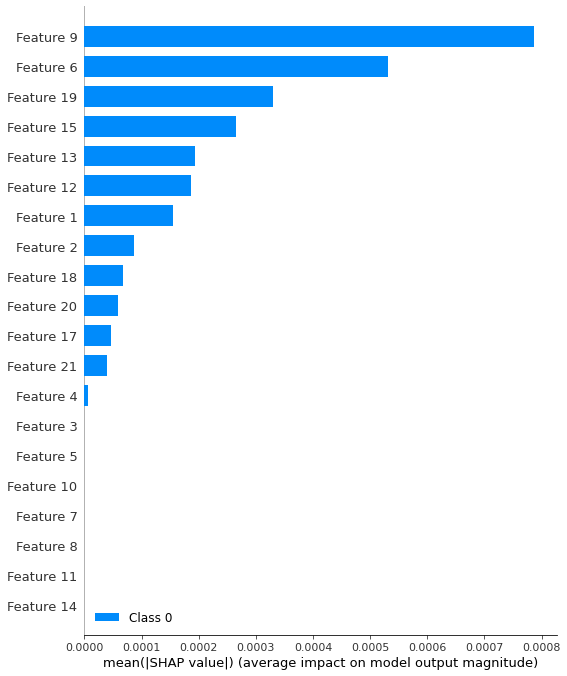

In [45]:
e = shap.DeepExplainer(saved_models[9], X_train[:1000])
shap_values = e.shap_values(X_test[:5])
shap.summary_plot(shap_values, X_train, plot_type="bar")